In [1]:
import bokeh
import bokeh.models
import bokeh.plotting
import numpy as np
import os
import pandas as pd
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
from tensorflow_text import SentencepieceTokenizer
import sklearn.metrics.pairwise

from simpleneighbors import SimpleNeighbors
from tqdm import tqdm
from tqdm import trange
import subprocess

In [2]:
#@title Setup common imports and functions


def visualize_similarity(embeddings_1, embeddings_2, labels_1, labels_2,
                         plot_title,
                         plot_width=1200, plot_height=600,
                         xaxis_font_size='12pt', yaxis_font_size='12pt'):

  assert len(embeddings_1) == len(labels_1)
  assert len(embeddings_2) == len(labels_2)

  # arccos based text similarity (Yang et al. 2019; Cer et al. 2019)
  sim = 1 - np.arccos(
      sklearn.metrics.pairwise.cosine_similarity(embeddings_1,
                                                 embeddings_2))/np.pi

  embeddings_1_col, embeddings_2_col, sim_col = [], [], []
  for i in range(len(embeddings_1)):
    for j in range(len(embeddings_2)):
      embeddings_1_col.append(labels_1[i])
      embeddings_2_col.append(labels_2[j])
      sim_col.append(sim[i][j])
  df = pd.DataFrame(zip(embeddings_1_col, embeddings_2_col, sim_col),
                    columns=['embeddings_1', 'embeddings_2', 'sim'])

  mapper = bokeh.models.LinearColorMapper(
      palette=[*reversed(bokeh.palettes.YlOrRd[9])], low=df.sim.min(),
      high=df.sim.max())

  p = bokeh.plotting.figure(title=plot_title, x_range=labels_1,
                            x_axis_location="above",
                            y_range=[*reversed(labels_2)],
                            plot_width=plot_width, plot_height=plot_height,
                            tools="save",toolbar_location='below', tooltips=[
                                ('pair', '@embeddings_1 ||| @embeddings_2'),
                                ('sim', '@sim')])
  p.rect(x="embeddings_1", y="embeddings_2", width=1, height=1, source=df,
         fill_color={'field': 'sim', 'transform': mapper}, line_color=None)

  p.title.text_font_size = '12pt'
  p.axis.axis_line_color = None
  p.axis.major_tick_line_color = None
  p.axis.major_label_standoff = 16
  p.xaxis.major_label_text_font_size = xaxis_font_size
  p.xaxis.major_label_orientation = 0.25 * np.pi
  p.yaxis.major_label_text_font_size = yaxis_font_size
  p.min_border_right = 300

  bokeh.io.output_notebook()
  bokeh.io.show(p)


In [3]:
# The 16-language multilingual module is the default but feel free
# to pick others from the list and compare the results.
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #@param ['https://tfhub.dev/google/universal-sentence-encoder-multilingual/3', 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3']

model = hub.load(module_url)

def embed_text(input):
  return model(input)

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

In [5]:
# Load the pretrained model
model = models.resnet50(pretrained=True)

# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()
# print(model)
# Image transforms
scaler = transforms.Scale((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vector(image_name):
    # 1. Load the image with Pillow library
    img = Image.open(image_name)
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(2048)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.reshape(o.data.size(1)))
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    newmodel(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding.numpy()

/home/sergey/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:318: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [5]:
final_df = pd.read_pickle('filtered_dataset_v2_views_dropna.pkl')

In [3]:
final_df = final_df.loc[final_df['perc_unk_words_re'] < 0.35]

In [6]:
final_df = pd.read_pickle('/home/sergey/maga_diploma/models/OCR_Speller/final_dataset_social_08_06_22_v2.pkl')

In [7]:
final_df.shape

(176781, 28)

In [93]:
final_df.sample(10)

,id_community,id_post,date_posted,count_likes,count_views,count_comments,count_reposts,text_post,image_url,post_url,...,level_sentiment_post_2,sentiment_text_ocr_image_1,sentiment_text_ocr_image_2,level_sentiment_ocr_1,level_sentiment_ocr_2,description_image,spell_text_with_re,perc_unk_words,perc_unk_words_re,full_text
198482,-25679656,17211,2013-09-05 19:30:00,1236,NaN,0,177,NaN,https://sun1-94.userapi.com/s/v1/if2/7d83ZXNd2...,https://vk.com/wall-25679656_17211,...,NaN,neutral,negative,0.731069,0.300756,a man in a suit and tie talking into a microphone,если кто-то борется коррупцией он сам должен б...,0.190476,0.100000,если кто-то борется коррупцией он сам должен б...
95846,-91050183,5174497,2019-08-28 18:43:00,40172,478107.0,0,117,NaN,https://sun1-93.userapi.com/s/v1/if2/OAXcWS9qC...,https://vk.com/wall-91050183_5174497,...,NaN,neutral,skip,0.334599,0.132974,a man laughing while standing in front of a pa...,у чувака пошла кровь из носа и он просит тридц...,0.187500,0.000000,у чувака пошла кровь из носа и он просит тридц...
108666,-91050183,64380,2017-06-18 18:51:00,15509,344892.0,0,585,NaN,https://sun1-87.userapi.com/s/v1/if2/e6vgBn0J7...,https://vk.com/wall-91050183_64380,...,NaN,skip,negative,0.287778,0.245095,NaN,женщины могут любить до потери пульса но потом...,0.093750,0.031250,женщины могут любить до потери пульса но потом...
193918,-25679656,27375,2014-03-23 20:40:00,1685,NaN,0,102,NaN,https://sun1-24.userapi.com/s/v1/if1/4m8BnnKCm...,https://vk.com/wall-25679656_27375,...,NaN,neutral,skip,0.685959,0.250923,NaN,план на сегодня смейся над тем какие все идио...,0.333333,0.000000,план на сегодня смейся над тем какие все идиот...
123940,-28468381,273445,2021-12-25 15:35:00,379,16637.0,11,164,NaN,https://sun1-23.userapi.com/s/v1/if2/rMozP4C5S...,https://vk.com/wall-28468381_273445,...,NaN,neutral,negative,0.430157,0.294225,NaN,грустная история естьу нас в донецке такая ули...,0.200000,0.083333,грустная история нас в такая улица называется ...
129621,-28468381,211717,2021-01-25 18:36:00,178,27699.0,5,203,1 бутер и ложусь спать �,https://sun1-28.userapi.com/s/v1/if2/hJMmcj2aS...,https://vk.com/wall-28468381_211717,...,0.300756,NaN,NaN,NaN,NaN,a cup of coffee with a pile of cookies,NaN,NaN,NaN,и ложусь спать
136456,-28468381,134437,2019-12-14 19:36:00,200,18164.0,0,17,NaN,https://sun1-13.userapi.com/c858036/v858036701...,https://vk.com/wall-28468381_134437,...,NaN,negative,skip,0.430157,0.314061,NaN,некоторые пешеходы так нагло переходят дорогу ...,0.181818,0.000000,некоторые пешеходы так нагло переходят дорогу ...
174287,-25679656,95620,2017-09-13 19:40:00,1943,91995.0,0,148,NaN,https://sun1-28.userapi.com/s/v1/if1/dGjz4Njqe...,https://vk.com/wall-25679656_95620,...,NaN,skip,negative,0.341593,0.275140,NaN,айфоны новые они значит придумали а лекарство ...,0.227273,0.045455,новые они значит придумали а лекарство чтоб со...
115430,-91050183,41539,2016-09-22 20:51:00,15365,NaN,0,1073,NaN,https://sun1-85.userapi.com/s/v1/if2/3rTncX81f...,https://vk.com/wall-91050183_41539,...,NaN,positive,negative,0.314061,0.201823,a poster of a cartoon bear walking on the beach,лучше быть любимой врединой чем никому не нужн...,0.111111,0.111111,лучше быть любимой чем никому не нужным соверш...
169389,-25679656,108878,2018-06-14 15:44:00,885,43110.0,0,54,NaN,https://sun1-98.userapi.com/s/v1/if2/F4-FSPRXe...,https://vk.com/wall-25679656_108878,...,NaN,neutral,negative,0.749097,0.222710,NaN,деиспе тйспъаи читать деистс если теория квант...,0.239437,0.109375,читать если теория квантового бессмертия верна...


In [103]:
final_df.loc[(final_df['type_post'] == "image") & (final_df['text_post'].notna()), 'type_post'] = 'img_text'

In [43]:
final_df.columns

Index(['id_community', 'id_post', 'date_posted', 'count_likes', 'count_views',
       'count_comments', 'count_reposts', 'text_post', 'image_url', 'post_url',
       'type_post', 'text_ocr_image', 'size_text_ocr', 'spell_text_ocr_image',
       'sentiment_text_post_1', 'sentiment_text_post_2',
       'level_sentiment_post_1', 'level_sentiment_post_2',
       'sentiment_text_ocr_image_1', 'sentiment_text_ocr_image_2',
       'level_sentiment_ocr_1', 'level_sentiment_ocr_2', 'description_image',
       'spell_text_with_re', 'perc_unk_words', 'perc_unk_words_re'],
      dtype='object')

In [1]:
with open('/home/sergey/maga_diploma/models/OCR_Speller/russian-words-master/russian.utf-8', 'r') as f:
    vocab = set(f.read().splitlines())

In [104]:
def prepare_full_text(row):
    if pd.notna(row['spell_text_with_re']):
        r = row['spell_text_with_re']
    elif pd.notna(row['spell_text_ocr_image']):
        r = row['spell_text_ocr_image']
    else:
        r = ''
    if pd.notna(row['text_post']):
        r = row['text_post'] + ' ' + r
        
    return delete_unknown(r)

In [105]:
import re
def delete_unknown(s): 
    # print(s)
    res = []
    for word in re.sub(r'[^А-Яа-яЁё\- ]', '', s.lower()).split():
        if word in vocab:
           res.append(word)
    return ' '.join(res)

In [106]:
final_df['full_text'] = final_df.apply(prepare_full_text, axis=1)

In [2]:
len(vocab)

1533166

In [ ]:
for index, row in tqdm(final_df.iterrows()):
    try:
        words = row['spell_text_with_re'].lower().split()
        res =  [w for w in words if w in vocab] if len(words) > 0 else np.nan
        if len(res) in (0, 1):
            continue
        final_df[index, 'clear_text'] = ' '.join(res)
    except:
        continue

19217it [12:00, 18.89it/s]

In [11]:
communities = dict(zip([-95355317, -57846937, -158490202, -131489096,  -91050183, -28468381,  -25679656], 
                       ['4ch', 'mudakoff', 'scolu', 'weirdreparametrizationtrick', 'dayvinchik', 'jokesss', 'sarsar']))

In [67]:
def distribution_pop(communities, my_df):
    cnt = 0
    base_dir = '/media/sergey/Transcend/Serega/maga_diplom/images_full/communities/'
    target_dir = '../popular/dataset/'
    for index, row in tqdm(my_df.iterrows()):
        cur_path = base_dir  + communities[int(row['id_community'])] + '/images/' + '_'.join([communities[int(row['id_community'])], str(row['id_community']), str(row['id_post'])]) + '.jpg'
        # command = '[ -f {} ] && echo "exist"'.format(cur_path)
        if not os.path.isfile(cur_path):
            print(cur_path)
            continue
        # print(cur_path)
        if row['pop_class'] == 0.0:
            command = 'cp {} {}'.format(cur_path, target_dir+'not_pop/')
            subprocess.call(command, shell=True)
        else:
            command = 'cp {} {}'.format(cur_path, target_dir+'is_pop/')
            subprocess.call(command, shell=True)
        cnt += 1
        # if cnt == 10:
        #     break
        #owner_id = img_path.split(os.sep)[-1].split('_')[1]
        #id_post = img_path.split(os.sep)[-1].split('_')[-1].split('.')[0]
        # print("_".join([communities[int(owner_id)], owner_id, id_post]) + '.jpg')
    return 0

In [76]:
distribution_pop(communities, final_df)

26497it [35:02, 12.61it/s]


0

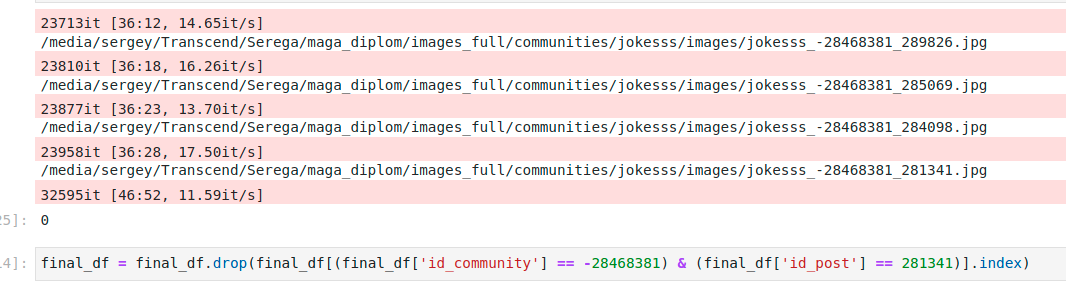

In [109]:
final_df['full_id'] = final_df.apply(lambda row: f"{row['id_community']}_{row['id_post']}", axis=1)

In [78]:
final_df.shape

(26497, 30)

In [ ]:
/home/sergey/maga_diploma/models/OCR_Speller/russian-words-master/russian.utf-8

In [31]:
final_df.columns

Index(['id_community', 'id_post', 'date_posted', 'count_likes', 'count_views',
       'count_comments', 'count_reposts', 'text_post', 'image_url', 'post_url',
       'type_post', 'text_ocr_image', 'size_text_ocr', 'spell_text_ocr_image',
       'sentiment_text_post_1', 'sentiment_text_post_2',
       'level_sentiment_post_1', 'level_sentiment_post_2',
       'sentiment_text_ocr_image_1', 'sentiment_text_ocr_image_2',
       'level_sentiment_ocr_1', 'level_sentiment_ocr_2', 'description_image',
       'spell_text_with_re', 'perc_unk_words', 'perc_unk_words_re',
       'pop_class', 'likes_per_views', 'id_community_str'],
      dtype='object')

In [80]:
imgs1 = ! ls /home/sergey/maga_diploma/models/popular/dataset/is_pop/*

In [81]:
imgs2 = ! ls /home/sergey/maga_diploma/models/popular/dataset/not_pop/*

In [82]:
lst_imgs = imgs1 + imgs2

In [128]:
final_df.head()

,id_community,id_post,date_posted,count_likes,count_views,count_comments,count_reposts,text_post,image_url,post_url,...,level_sentiment_ocr_1,level_sentiment_ocr_2,description_image,spell_text_with_re,perc_unk_words,perc_unk_words_re,likes_per_views,pop_class,full_text,full_id
1,-95355317,2106041,2022-05-12 12:03:02,6,6342.0,4,9,NaN,https://sun1-18.userapi.com/s/v1/ig2/gwRD8wNJH...,https://vk.com/wall-95355317_2106041,...,0.986787,0.016925,the evolution of korean beauty in 2018 and 2020,когда вс жизнь мечтала стать парнем,0.666667,0.000000,0.000946,NaN,когда вс жизнь мечтала стать парнем,-95355317_2106041
3,-95355317,2106029,2022-05-12 10:03:00,9,8934.0,7,5,NaN,https://sun1-55.userapi.com/s/v1/ig2/iyfPNRSKA...,https://vk.com/wall-95355317_2106029,...,0.976321,0.275140,a small console table is made out of a metal,не могу понять стоит или лежит,0.000000,0.000000,0.001007,0.0,не могу понять стоит или лежит,-95355317_2106029
5,-95355317,2105981,2022-05-11 19:10:00,378,23118.0,2,161,NaN,https://sun1-96.userapi.com/s/v1/ig2/0Etc7GMf3...,https://vk.com/wall-95355317_2105981,...,0.362979,0.239359,the face of a monkey on a screenshot of a cell...,влад крутится ли воздух внутри колеса вчера в ...,0.354167,0.125000,0.016350,1.0,крутится ли воздух внутри колеса вчера в ответ...,-95355317_2105981
6,-95355317,2105977,2022-05-11 17:10:00,32,5581.0,0,42,NaN,https://sun1-83.userapi.com/s/v1/ig2/YQU9ENzXN...,https://vk.com/wall-95355317_2105977,...,0.992889,0.020974,a screenshot of a cell phone message with a cake,это мы когда отмечаете один день без ссор ещё...,0.272727,0.058824,0.005733,NaN,это мы когда отмечаете один день без ссор ещё ...,-95355317_2105977
8,-95355317,2105968,2022-05-11 12:10:00,19,5397.0,0,23,NaN,https://sun1-54.userapi.com/s/v1/ig2/2mVk4bj_j...,https://vk.com/wall-95355317_2105968,...,0.737168,0.445540,a woman is making a bed with a clock,сегоднялягулоракьше интересно что такого случ...,0.250000,0.083333,0.003520,NaN,интересно что такого случилось у гоголя что ок...,-95355317_2105968


In [6]:
ids_feat, all_vec = [], []

In [25]:
final_df['full_id'] = final_df.apply(lambda row: f"{row['id_community']}_{row['id_post']}", axis=1)

In [33]:
def get_all_vec(communities, my_df):
    cnt = 0
    all_vec = []
    ids_feat = []
    base_dir = '/media/sergey/Transcend/Serega/maga_diplom/images_full/communities/'
    target_dir = '../popular/dataset/'
    # cnt = 0 
    for index, row in tqdm(my_df.iterrows()):
        # cnt += 1
        # if cnt == 10:
            # break
        if row['type_post'] == "text":
            continue
        cur_path = base_dir  + communities[int(row['id_community'])] + '/images/' + '_'.join([communities[int(row['id_community'])], str(row['id_community']), str(row['id_post'])]) + '.jpg'
        # command = '[ -f {} ] && echo "exist"'.format(cur_path)
        
        if not os.path.isfile(cur_path):
            # print(cur_path)
            continue
        try:
            vec_img = get_vector(cur_path)
            ids_feat.append(row['full_id'])
            all_vec.append(vec_img)
        except:
            continue
            # print(cur_path)
    # print(ids_feat)
    return ids_feat, all_vec

In [34]:
ids_feat, all_vec = get_all_vec(communities, final_df)

176781it [3:01:58, 16.19it/s] 


In [86]:
all_vec = []
ids_feat = []
for img in tqdm(lst_imgs):
    try:
        vec_img = get_vector(img)
        full_id_path = '_'.join(img.rstrip('.jpg').split('/')[-1].split('_')[-2:])
        ids_feat.append(full_id_path)
        all_vec.append(vec_img)
    except:
        print(img)

 10%|▉         | 2635/26496 [02:53<26:31, 14.99it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/dayvinchik_-91050183_2440670.jpg


 14%|█▍        | 3800/26496 [04:09<20:35, 18.37it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/jokesss_-28468381_135343.jpg


 14%|█▍        | 3836/26496 [04:11<19:57, 18.92it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/jokesss_-28468381_137012.jpg
/home/sergey/maga_diploma/models/popular/dataset/is_pop/jokesss_-28468381_137025.jpg


 15%|█▍        | 3879/26496 [04:14<20:41, 18.22it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/jokesss_-28468381_139330.jpg


 16%|█▌        | 4296/26496 [04:40<20:05, 18.41it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/jokesss_-28468381_220785.jpg


 17%|█▋        | 4431/26496 [04:49<22:00, 16.71it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/jokesss_-28468381_256434.jpg


 23%|██▎       | 6104/26496 [06:41<20:36, 16.49it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/mudakoff_-57846937_22123466.jpg


 33%|███▎      | 8809/26496 [09:53<18:41, 15.76it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/mudakoff_-57846937_39278132.jpg


 37%|███▋      | 9908/26496 [11:08<16:03, 17.22it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/sarsar_-25679656_1034015.jpg


 38%|███▊      | 10027/26496 [11:16<16:57, 16.18it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/sarsar_-25679656_107972.jpg


 38%|███▊      | 10050/26496 [11:18<16:08, 16.98it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/sarsar_-25679656_108869.jpg


 43%|████▎     | 11351/26496 [12:47<15:15, 16.54it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/sarsar_-25679656_83882.jpg
/home/sergey/maga_diploma/models/popular/dataset/is_pop/sarsar_-25679656_839477.jpg


 43%|████▎     | 11367/26496 [12:48<15:22, 16.41it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/sarsar_-25679656_84327.jpg


 43%|████▎     | 11500/26496 [12:57<14:35, 17.14it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/sarsar_-25679656_88274.jpg


 45%|████▍     | 11799/26496 [13:18<14:32, 16.85it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/sarsar_-25679656_98426.jpg


 48%|████▊     | 12796/26496 [14:29<12:57, 17.62it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/scolu_-158490202_245450.jpg


 48%|████▊     | 12836/26496 [14:31<13:43, 16.59it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/scolu_-158490202_323849.jpg


 49%|████▊     | 12873/26496 [14:34<13:47, 16.47it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/scolu_-158490202_450214.jpg


 49%|████▉     | 13020/26496 [14:44<13:19, 16.85it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/scolu_-158490202_829494.jpg


 49%|████▉     | 13079/26496 [14:48<12:54, 17.31it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/scolu_-158490202_939725.jpg


 49%|████▉     | 13104/26496 [14:49<13:08, 16.98it/s]

/home/sergey/maga_diploma/models/popular/dataset/is_pop/scolu_-158490202_982290.jpg


 53%|█████▎    | 13987/26496 [15:48<11:52, 17.55it/s]

/home/sergey/maga_diploma/models/popular/dataset/not_pop/4ch_-95355317_2007396.jpg


 63%|██████▎   | 16638/26496 [18:48<08:25, 19.52it/s]

/home/sergey/maga_diploma/models/popular/dataset/not_pop/jokesss_-28468381_132157.jpg


 63%|██████▎   | 16807/26496 [18:58<09:05, 17.76it/s]

/home/sergey/maga_diploma/models/popular/dataset/not_pop/jokesss_-28468381_137911.jpg


 64%|██████▎   | 16836/26496 [19:00<09:08, 17.63it/s]

/home/sergey/maga_diploma/models/popular/dataset/not_pop/jokesss_-28468381_138603.jpg


 64%|██████▎   | 16857/26496 [19:01<09:10, 17.52it/s]

/home/sergey/maga_diploma/models/popular/dataset/not_pop/jokesss_-28468381_139189.jpg


 64%|██████▎   | 16876/26496 [19:03<09:12, 17.41it/s]

/home/sergey/maga_diploma/models/popular/dataset/not_pop/jokesss_-28468381_139613.jpg


 64%|██████▍   | 17049/26496 [19:14<10:14, 15.38it/s]

/home/sergey/maga_diploma/models/popular/dataset/not_pop/jokesss_-28468381_160670.jpg


 85%|████████▌ | 22586/26496 [25:28<04:00, 16.29it/s]

/home/sergey/maga_diploma/models/popular/dataset/not_pop/sarsar_-25679656_101128.jpg


 86%|████████▌ | 22769/26496 [25:40<03:35, 17.29it/s]

/home/sergey/maga_diploma/models/popular/dataset/not_pop/sarsar_-25679656_106320.jpg


 90%|█████████ | 23972/26496 [27:03<02:33, 16.39it/s]

/home/sergey/maga_diploma/models/popular/dataset/not_pop/sarsar_-25679656_450628.jpg


 91%|█████████ | 24029/26496 [27:07<02:25, 16.95it/s]

/home/sergey/maga_diploma/models/popular/dataset/not_pop/sarsar_-25679656_524946.jpg


 91%|█████████▏| 24208/26496 [27:20<02:30, 15.24it/s]

/home/sergey/maga_diploma/models/popular/dataset/not_pop/sarsar_-25679656_727723.jpg


100%|█████████▉| 26454/26496 [29:52<00:02, 15.24it/s]

/home/sergey/maga_diploma/models/popular/dataset/not_pop/scolu_-158490202_929114.jpg


100%|██████████| 26496/26496 [29:55<00:00, 14.76it/s]


In [35]:
df_ids_f = pd.DataFrame(ids_feat, columns =['full_id'])

In [36]:
df_features = pd.DataFrame(np.vstack(all_vec), index=df_ids_f['full_id'], columns=list(map(lambda x: f'r{x:04d}', range(all_vec[0].shape[0]))))

In [38]:
df_features.shape

(110827, 2048)

In [39]:
df_features.to_pickle('features_v2_clear_text.pkl')

In [93]:
df_features.to_pickle('features_v2_views_perc.pkl')

In [4]:
df_features = pd.read_pickle('features_v2_views_perc.pkl')

In [ ]:
final_df.query('type_post != "text"')

In [120]:
lst_embeds = []
for index, row in tqdm(final_df.iterrows()):
    s1 = embed_text([row['full_text']]).numpy()
    if pd.isna(row['description_image']):
        s2 = np.zeros((1,512))
    else:
        s2 = embed_text([row['description_image']]).numpy()
    
    # s2 = embed_text([row['spell_text_with_re']]).numpy()
    # s3 = embed_text([row['text_post']]).numpy()     #s3 - для опционального текста
    lst_embeds.append(np.hstack((s1, s2)))
    # break
    # s3_s1 = np.append(s3, s1)
    # lst_embeds.append(s3_s1)

176781it [26:45, 110.12it/s]


In [119]:
lst_embeds[0].shape

(1, 1024)

In [121]:
ids_e = final_df.apply(lambda row: f"{row['id_community']}_{row['id_post']}", axis=1)

In [41]:
df_class = final_df.set_index('full_id')['pop_class']

In [123]:
df_embed_features = pd.DataFrame(np.vstack(lst_embeds), ids_e, columns=list(map(lambda x: f'e{x:04d}', range(1024))))
df_embed_features

,e0000,e0001,e0002,e0003,e0004,e0005,e0006,e0007,e0008,e0009,...,e1014,e1015,e1016,e1017,e1018,e1019,e1020,e1021,e1022,e1023
-95355317_2106041,-0.050202,-0.005405,0.021376,-0.051566,-0.074584,0.023328,0.047106,0.056403,-0.059047,-0.047148,...,-0.024406,-0.041011,0.018773,0.064249,0.066774,0.043847,-0.024818,-0.010845,0.026412,0.038456
-95355317_2106029,0.003180,-0.026837,0.001380,-0.040814,-0.114463,0.009222,-0.029019,-0.046554,-0.105187,-0.007478,...,-0.017926,0.014094,-0.043782,0.054934,-0.061859,0.053387,-0.061283,-0.078392,-0.028585,-0.043558
-95355317_2105981,-0.018150,0.062485,-0.047640,0.046038,-0.028603,0.043973,0.050460,0.019902,-0.043200,-0.013904,...,-0.061047,-0.003726,0.042038,0.009857,0.001314,0.066375,-0.025699,0.014016,0.064210,0.016947
-95355317_2105977,-0.025884,0.049966,-0.010241,0.005267,0.030446,0.042081,0.029399,0.011158,-0.008990,0.018523,...,-0.033345,-0.032393,0.043702,-0.016369,-0.007129,0.089308,-0.043543,0.047753,0.069570,0.011778
-95355317_2105968,-0.061749,0.064719,-0.078596,-0.080345,-0.020010,0.047103,0.031237,0.009989,-0.020443,0.020826,...,-0.055325,-0.081176,0.064289,0.012770,0.014142,-0.010850,-0.089058,0.007772,0.031373,-0.013116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-25679656_1295,-0.043813,-0.033101,0.000426,-0.048782,-0.072084,-0.024985,-0.039337,-0.043402,-0.052349,-0.035921,...,-0.012747,0.010299,-0.010067,-0.055705,-0.032774,0.026927,0.029782,0.050931,0.066514,0.016577
-25679656_1294,0.019727,0.012492,-0.023962,-0.052555,0.027313,-0.014003,-0.008594,0.011278,-0.096872,0.000239,...,-0.032170,-0.093976,0.065428,-0.011611,0.011752,0.071408,0.071169,0.032212,0.075119,0.013449
-25679656_1293,0.100036,0.020600,-0.028816,-0.002237,-0.115259,-0.019824,-0.003626,0.056648,0.039402,0.025474,...,-0.050547,-0.078467,0.055211,0.011293,0.029411,0.071183,0.022823,0.015634,-0.009399,-0.028487
-25679656_1289,-0.076138,-0.049887,-0.020162,-0.014407,0.042206,-0.008082,-0.031086,0.053580,-0.070373,0.014257,...,-0.053842,-0.017229,0.056438,-0.012517,-0.086537,0.006583,0.025379,0.015859,0.065609,-0.007963


In [124]:
df_embed_features.to_pickle('embeds_clear_text.pkl.bz2')

In [40]:
df_embed_features = pd.read_pickle('embeds_clear_text.pkl.bz2')

In [42]:
df_all = df_features.join(df_embed_features, how='inner').join(df_class, how='inner')

In [43]:
df_all.shape

(110833, 3073)

In [44]:
df_all.to_pickle('ready_for_learning_v2_clear_text_views.pkl.bz2')